SILVA-MARTINS Merlin

BRAUSCH Sébastien

# Devoir : physique statistique partie mécanique quantique.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline


In [2]:
#Paramètres pour l'affichage des graphes
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

# Question 1:

On voit directement que les solutions de cette équations sont des exponentielles de forme C*exp(k*x) où C et k sont des constantes
on doit donc résoudre l'équation suivante :
 $$
 C k^4 e^{k x} - 5C k^2e^{k^x} + 4 C e^{k x} = 0
 $$
En simplifiant, on voit directement apparaitre une équation du second degré en k, en résolvant on trouve le spectre suivant pour k : 
k = {-2, -1, 1, 2}. De plus si 2 fonctions sont solutions de l'équation différentielle, une combinaison linéaire de ces deux fonctions est aussi solution.  On a donc une solution générale pour notre équation :
$$
f(x) = C_1 e^{x} + C_2 e^{-x} + C_3e^{2x} + C_4e{-2x}
$$
où les $C_{i=1, 2, 3, 4}$ sont les constantes d'intégration qui seront discutées plus tard 

In [3]:
#On commence la discrétisation de notre domaine et la paramétrisation nécéssire à la suite du travail :
#On définit notre abscisse :
nx = 101  # nombre de points (entre x=0 et x=1)
Lx = 1.0  # domaine de définition
dx = Lx / (nx - 1)  #intervalle entre x[i] et x[i+1]

#BC :
a=0. #condition au bord (f(x = 0)
b=0. #                  (f'(x=0))
c=1. #                  (f(x=1))
d=-1. #                 (f'(x=1))

#On situe nos points sur la grille :
x = numpy.linspace(0.0, Lx, num=nx)

#Conditions initiales :
p0 = numpy.zeros(nx)
p0[-1] = c

# Question 2

Les constantes d'intégration peuvent être déterminées en résolvant le système d'équation linéaire obtenu en appliquant les conditions aux bords.
Ces dernières vont dépendre des paramètres a, b, c et d définis ci-dessus. Pour ce faire nous utiliserons une fonction de python numpy.linalg.solve() qui va résoudre ce système pour n'importe quels paramètres aux bords.

In [4]:
def resolvsyst (a,b,c,d):


    A = ([1,1,1,1],[1,-1,2,-2],[(numpy.exp(1)),(numpy.exp(-1)),(numpy.exp(2)),(numpy.exp(-2))],[(numpy.exp(1)),(-numpy.exp(-1)),(2*numpy.exp(2)),(-2*numpy.exp(-2))])
    A = numpy.array(A)
    t = numpy.array([a,b,c,d])
    y = numpy.linalg.solve(A,t)
    return y

On résout ce système pour les paramètres donnés dans l'énoncé, et on obtient donc la solution exacte de l'équation pour ces paramètres aux bords

# Question3

In [5]:
C = resolvsyst(0,0,1,-1)
pexact = C[0]*numpy.exp(x)+C[1]*numpy.exp(-x)+C[2]*numpy.exp(2*x)+C[3]*numpy.exp(-2*x)

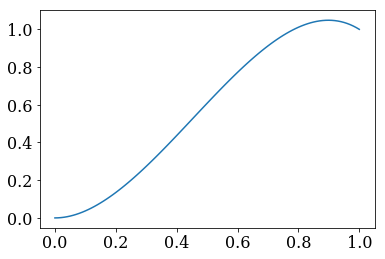

In [6]:
#On affiche cette fonction :
pyplot.plot(x,pexact)

On va maintenant s'intéresser aux méthodes de résolution numériques pour les équations différentielles. Pour Gauss-Seidel, on importe un outil augmentant la vitesse de calcul.

# Question 4

In [7]:
import numba
from numba import jit

Dans notre cas la discrétisation de la dérivée est donnée par :
$$
\frac{u_{i-2}-4u_{i-1}+6u_i-4u_{i+1}+u_{i+2}}{(\Delta x)^4}-5 \left( \frac{u_{i-1}-2u_i+u_{i+1}}{(\Delta x)^2}\right)+4u_i = 0
$$
Donc pour la méthode de Gauss-Seidel nous mettrons nos points "à jour" grâce à la relation suivante:

$$
p_{i}^{k+1} = \frac{1}{\beta} \left(-p_{i-2}^{k+1}-\gamma p_{i-1}^{k+1}-\gamma p_{i+1}^k - p_{i+2}^k\right)
$$
où $\beta = 6 + 10 dx^2+4dx^4$ et $\gamma = -4-5dx^2$

In [8]:
@jit(nopython=True)
def laplace_2d_gauss_seidel(dx,p0, maxiter=20000, rtol=1e-6):
    p = p0.copy()
    beta = 6+10*dx**2+4*dx**4
    gamma = -4-5*dx**2
    conv = []  
    diff = rtol + 1.0  
    ite = 0  

    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        for i in range(2,nx-2):
            p[i] = (1/beta)*(-p[i-2]-gamma*p[i-1]-gamma*p[i+1]-p[i+2])
                      
        p[-2]= p[-1]+dx
        p[1] = p[0]
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1 
    return p, ite, conv

Le code tourne jusqu'à ce que la différence relative entre deux valeurs successives de la fonction soient suffisement petites.
On veut ici savoir combien d'itérations ont été nécessaire pour arriver à une telle différence :

In [9]:
p, ites, conv_gs = laplace_2d_gauss_seidel(dx,p0,
                                           maxiter=20000000, rtol=1e-8)
print('Gauss-Seidel relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_gs[-1]))

Gauss-Seidel relaxation: 2531638 iterations to reach a relative difference of 9.99998581262672e-09


In [10]:
def L2_rel_error(p, pk):
    return numpy.sqrt(numpy.sum((p - pk)**2)/numpy.sum(pk**2))

In [11]:
print("la norme L2 pour notre fonction est:", L2_rel_error(p,pexact))

la norme L2 pour notre fonction est: 0.005822656840975767


Ici on compare graphiquement notre solution exacte (en orange) et la fonction obtenue par Gauss-Seidel (en bleu)
On voit qu'elles sont pratiquement confondues, on a donc très bien approché la solution avec cette méthode.

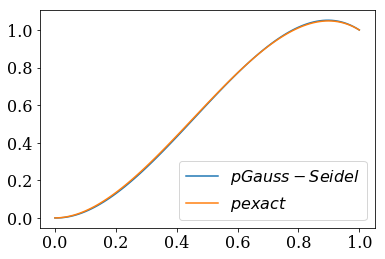

In [12]:
pyplot.plot(x,p,label=r'$p Gauss-Seidel$')
pyplot.plot(x,pexact,label=r'$pexact$')
pyplot.legend()

# Question 5

On va maintenant tenter de résoudre avec la méthode du gradient conjugué :

In [13]:
def conjugate_gradient(p0, dx,
                       maxiter=20000, rtol=1e-7):
    #On va définir l'opérateur différentiel qui agit sur notre fonction en utilisant la finite central difference :
    def A(p):
        return ((p[:-4] - 4 * p[1:-3] + 6 * p[2:-2] - 4 * p[3:-1]  + p[4:]) / dx**4) - (5 * (p[1:-3] - 2 * p[2:-2] + p[3:-1]) / dx**2) + 4 * p[2:-2]
    p = p0.copy()
    p[-1] = 1
    p[-2]= p[-1]+dx
    p[0] = 0
    p[1] = p[0]
    r = numpy.zeros_like(p)  # on règle le résidus initial
    Ad = numpy.zeros_like(p)  # permet de multiplier les différentes quantités considérées
    conv = []  # convergence 
    diff = rtol + 1  # difference initiale
    ite = 0  # indexe d'itération. Comme pour Gauss, on veut connaitre le nombre d'itération décessaire à la résolution de notre équation
    # On compute le résidus initial. Ici il n'y a pas de terme de sources, l'équation est homogène. Notre fonction conjugate_gradient ne dépendra donc pas du paramètre b (comme il est défini dans le cours)
    r[2:-2] = - A(p)
    # On règle la rechere de direction initiale pour être le résidus
    d = r.copy()
    # On va maintenant run notre code. Celui ci ne s'arrêtera pas tant que le nombre d'itérations max ne soit atteint ou que la différence relative entre deux points successifs soit suffisement petite
    while diff > rtol and ite < maxiter:
        pk = p.copy()
        rk = r.copy()
        
        Ad[2:-2] = A(d)
        # On règle la taille des pas.
        alpha = numpy.sum(r * r) / numpy.sum(d * Ad)
        # On met la solution et le résidus à jour.
        p = pk + alpha * d
        r = rk - alpha * Ad
        # Ainsi que la directon.
        beta = numpy.sum(r * r) / numpy.sum(rk * rk)
        d = r + beta * d
        # Les conditions de Dirichlet sont automatiquement implémentées, il nous restes les conditions de Van Neumann à computer.
        # On utilise la forward finite diff pour la condition à gauche, et la backward pour celle de droite :
        p[-2]= p[-1]+dx
        p[1] = p[0]
        # Et on calcule la différence relative, lorsqu'elle sera suffisement faible, on sortira de la boucle.
        diff =  L2_rel_error(p, pk)
        conv.append(diff)
        ite += 1
    return p, ite, conv

 On compute la solution trouvée avec cette méthode, et on demande aussi le nombre d'itération nécessaires.

In [14]:
p, ites, conv_cg = conjugate_gradient(p0, dx, 
                                      maxiter=20000, 
                                      rtol=1e-10)
print('Method of conjugate gradients: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_cg[-1]))

Method of conjugate gradients: 314 iterations to reach a relative difference of 7.118325472842683e-11


Le nombre d'itérations trouvés ici est nettement plus faible que pour la méthode de Gauss-Seidel.

In [15]:
print("La norme L2 pour cette méthode est:",L2_rel_error(p, pexact))

La norme L2 pour cette méthode est: 0.0051601985540429916


Ce nombre est comparable à celui obtenu pour la méthode de Gauss-Seidel

Comparons le graphique de notre solution avec la solution exacte.

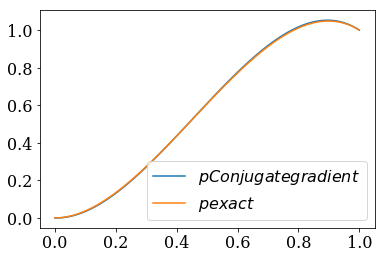

In [16]:
pyplot.plot(x,p,label=r'$p Conjugate gradient$')
pyplot.plot(x,pexact,label=r'$pexact$')
pyplot.legend()

On voit qu'ils se superposent bien et que notre algoritme fonctionne. Notons que la grande différence entre ces méthodes est le nombre d'itérations nécessaires avant d'avoir une norme L2 du même ordre de grandeur.